# Predicting breast cancer using data from AzureML

This notebook demonstrates a simple machine learning process to predict breast cancer incidence. The data residdes in the Azure Machine Learning Studio, and this example download the data to the notebook and then fits a simple regression model. The `AzureML` package allows you to import datasets from the AzureML-Studio to your local R session, or indeed a notebook.


## About the data
The `Breast cancer data` is one of three cancer-related datasets provided by the Oncology Institute that appears frequently in machine learning literature. Combines diagnostic information with features from laboratory analysis of about 300 tissue samples.

Usage: Classify the type of cancer, based on 9 attributes, some of which are linear and some are categorical.

Related Research: Wohlberg, W.H., Street, W.N., & Mangasarian, O.L. (1995). UCI Machine Learning Repository http://archive.ics.uci.edu/ml. Irvine, CA: University of California, School of Information and Computer Science

## Importing data from AzureML

By default, the `AzureML` package is installed on the Jupyter server. The `AzureML` package allows you to import datasets from the AzureML-Studio to your local R session.

You use the `workspace()` function to configure a connection to your AzureML Studio workspace.

Note that the Jupyter workspace in AzureML already contains a file at `~/.azureml/setting.json` that contains your workspace credentials. This has the benefit that you won't reveal your credentials when sharing the notebook.

Thus, when you use `workspace()` with a Jupyter notebook, you don't have to provide your credentials.

Use the function `download.intermediate.dataset()` to download the data from the AzureML Studio to your Jupyter notebook.

In [8]:
library("AzureML")
ws <- workspace()
dat <- download.datasets(ws, "Breast cancer data")

Once the data is downloaded to your Jupyter session, you can use any R function to inspect or manipulate the data.

For example, inspect the structure of your dataset using `str()`:

In [9]:
str(dat)

'data.frame':	683 obs. of  10 variables:
 $ Class      : num  0 0 0 0 0 1 0 0 0 0 ...
 $ age        : num  5 5 3 6 4 8 1 2 2 4 ...
 $ menopause  : num  1 4 1 8 1 10 1 1 1 2 ...
 $ tumor-size : num  1 4 1 8 1 10 1 2 1 1 ...
 $ inv-nodes  : num  1 5 1 1 3 8 1 1 1 1 ...
 $ node-caps  : num  2 7 2 3 2 7 2 2 2 2 ...
 $ deg-malig  : num  1 10 2 4 1 10 10 1 1 1 ...
 $ breast     : num  3 3 3 3 3 9 3 3 1 2 ...
 $ breast-quad: num  1 2 1 7 1 7 1 1 1 1 ...
 $ irradiat   : num  1 1 1 1 1 1 1 1 5 1 ...


The IRKernel displays data frames in a nice tabular format:

In [10]:
head(dat)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
1,0,5,1,1,1,2,1,3,1,1
2,0,5,4,4,5,7,10,3,2,1
3,0,3,1,1,1,2,2,3,1,1
4,0,6,8,8,1,3,4,3,7,1
5,0,4,1,1,3,2,1,3,1,1
6,1,8,10,10,8,7,10,9,7,1


## Plot  the correlation matrix

Notebooks allows you to plot data, and the plot gets displayed directly in the output.

Note you can install packages from MRAN (the Microsoft CRAN mirror). In this example, install the `corrgram` package to plot the correlation matrix.

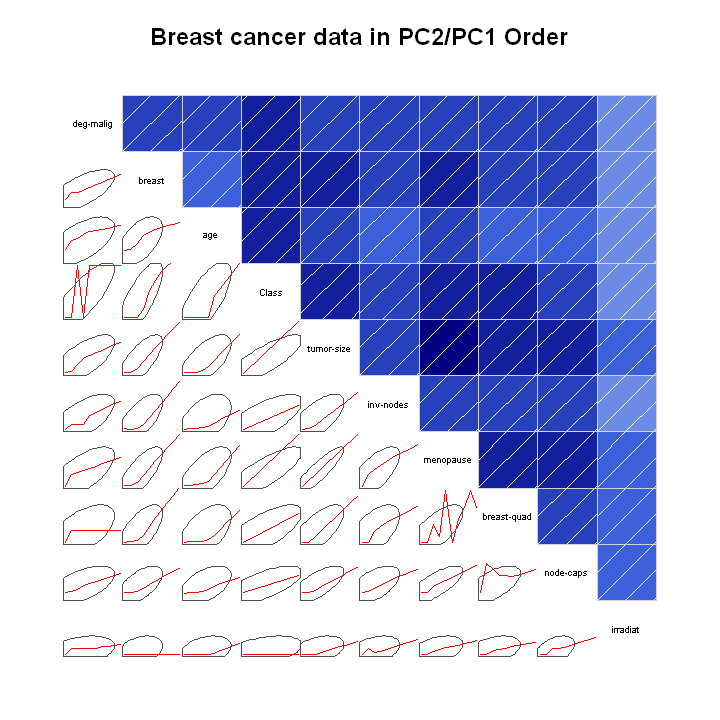

In [11]:
# Change plot size
options(jupyter.plot_mimetypes = 'image/png') 
options(repr.plot.width = 6, repr.plot.height = 6)

if(!require("corrgram", quietly = TRUE)) install.packages("corrgram")
library(corrgram, quietly = TRUE)
corrgram(dat, order = TRUE, 
         lower.panel = panel.ellipse,
         upper.panel = panel.shade, 
         text.panel = panel.txt,
         main = "Breast cancer data in PC2/PC1 Order",
         cex.labels = 0.7)


## Create a binary classifier model

The column `Class` in the breast cancer data is an indicator whether a person had breast cancer or not. Logistic regression is an algorithm that allows you to fit a binary classifier to data. A binary classifier predicts data with two classes, for example TRUE or FALSE, or 1 or 0.

Using R, You can fit a logistic regression model using the `glm()` function.

But first, separate the data into a training and test sample.

In [12]:
set.seed(1)
idx <- sample.int(nrow(dat), nrow(dat) * 0.8) # create an 80% sample index
train <- dat[idx, ]  # keep the 80% sample
test  <- dat[-idx, ] # discard the 80% sample

# fit the model
model <- glm(Class ~ ., data = dat, family = binomial)

Now inspect the model using `summary()`. 

In [13]:
summary(model)


Call:
glm(formula = Class ~ ., family = binomial, data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4841  -0.1153  -0.0619   0.0222   2.4698  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -10.10394    1.17488  -8.600  < 2e-16 ***
age             0.53501    0.14202   3.767 0.000165 ***
menopause      -0.00628    0.20908  -0.030 0.976039    
`tumor-size`    0.32271    0.23060   1.399 0.161688    
`inv-nodes`     0.33064    0.12345   2.678 0.007400 ** 
`node-caps`     0.09663    0.15659   0.617 0.537159    
`deg-malig`     0.38303    0.09384   4.082 4.47e-05 ***
breast          0.44719    0.17138   2.609 0.009073 ** 
`breast-quad`   0.21303    0.11287   1.887 0.059115 .  
irradiat        0.53484    0.32877   1.627 0.103788    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 884.35  on 682  degrees of freedom
Residual dev

## Evaluate model accuracy

To evaluate the model accuracy, you can use the `ROCR` package to plot various ROC plots. ROC plots are widely used in machine learning to visualize model accuracy. The higher the area under the curve, the better the model. This is why this type of plot is sometimes also called AUC plots (Area Unde the Curve).

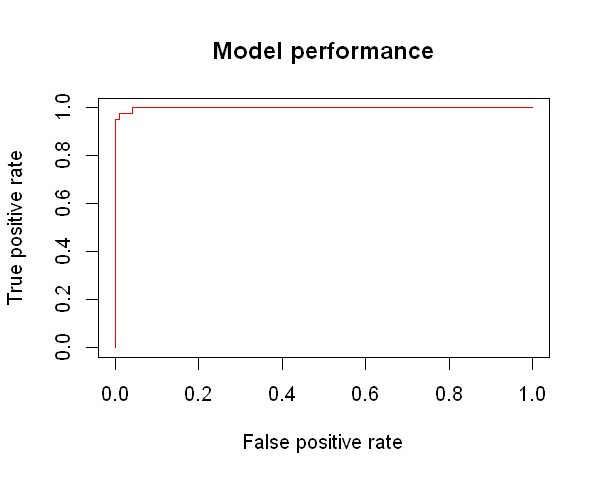

In [14]:
if(!require(ROCR, quietly = TRUE)) install.packages("ROCR")
library(ROCR, quietly = TRUE)

# First, create predictions using the holdout (test) set
predictions <- predict(model, test, type = "response")

# Using ROCR's 3 commands to produce a simple ROC plot:

pred <- prediction(predictions, test$Class)
perf <- performance(pred, measure = "tpr", x.measure = "fpr") 
    
    
options(repr.plot.width = 5, repr.plot.height = 4)
plot(perf, col = rainbow(10), main = "Model performance")



The model performs very well using the test data.